<a href="https://colab.research.google.com/github/Yuji-ONUKI/GCI2020_Winter/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

print('Importing data...')
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
record = pd.read_csv("/content/drive/MyDrive/Record.csv")
client = pd.read_csv("/content/drive/MyDrive/Client.csv")

Importing data...
Mounted at /content/drive


In [ ]:
record.columns

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
       'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
       'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'churn', 'months'],
      dtype='object')

In [ ]:
record['rev_Mean'].describe()

count    99643.000000
mean        58.719985
std         46.291677
min         -6.167500
25%         33.260000
50%         48.195000
75%         70.750000
max       3843.262500
Name: rev_Mean, dtype: float64

In [ ]:
#record.describe()

In [ ]:
for col in record.columns:
  if(record[col].min()<0):
    print(col)

rev_Mean
totmrc_Mean
change_mou
change_rev


In [ ]:
cols_min = ['rev_Mean',
'totmrc_Mean',
'change_mou',
'change_rev']

In [ ]:
#for col in cols_min:
#  print(col,'\t',record.loc[record[col]<0,col].count())

rev_Mean:
Mean monthly revenue (charge amount)

totmrc_Mean:
Mean total monthly recurring charge 定期的な料金

change_mou:
Percentage change in monthly minutes of use vs previous three month average

change_rev:
Percentage change in monthly revenue vs previous three month average

In [ ]:
#record.loc[record['rev_Mean']<0]

10万レコード同士なので両者対応していると考える。

In [4]:
df=pd.concat([client,record],axis=1)
#org=df
#df=record

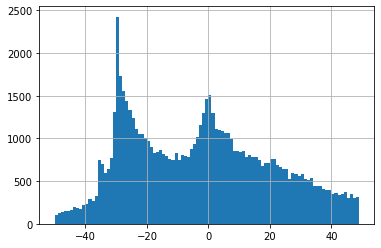

In [15]:
df['check3']=df['avgrev']*df['months']-df['totrev']
df['check3'].hist(bins=range(-50,50,1))

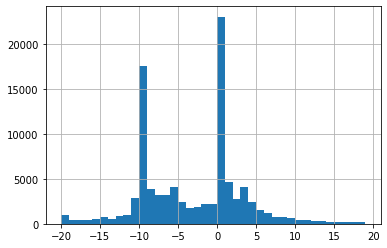

In [5]:
df['check4']=df['rev_Mean']-(df['ovrrev_Mean']+df['totmrc_Mean'])
df['check4'].hist(bins=range(-20,20,1))

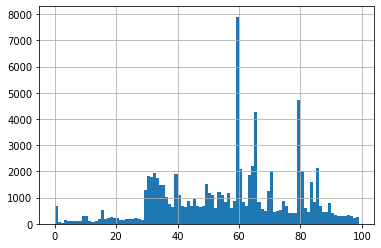

In [8]:
df['check5']=df['totrev']-(df['adjrev'])
df['check5'].hist(bins=range(0,100,1))

# お得な割引制度の存在を示唆

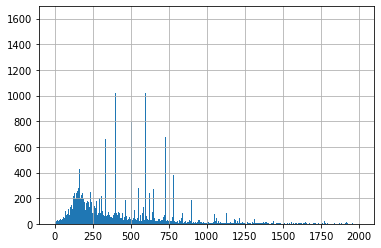

In [28]:
df['check6']=(df['totrev']-df['adjrev'])/df['months']*100
df['check6'].hist(bins=range(0,2000,1))

In [27]:
df['check6'].mode()

0    5.964545
dtype: float64

# 短期顧客を優遇する割引制度

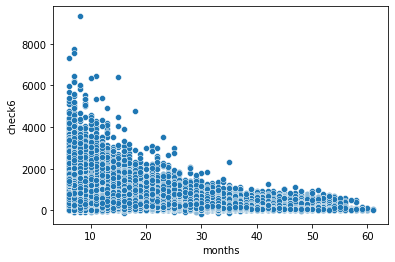

In [29]:
sns.scatterplot(x='months',y='check6',data=df)

In [ ]:
df['avg_rev']=df['totrev']/df['months']

In [ ]:
df['check']=df['avg_rev']-df['rev_Mean']

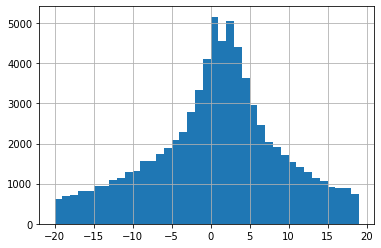

In [ ]:
df['check'].hist(bins=range(-20,20,1))

In [ ]:
df.loc[(df['check']<20)&(df['check']>-20)].count()/df.count()

uniqsubs         0.762580
actvsubs         0.762580
new_cell         0.762580
crclscod         0.762580
asl_flag         0.762580
                   ...   
callwait_Mean    0.762580
churn            0.762580
months           0.762580
avg_rev          0.762580
check            0.765312
Length: 102, dtype: float64

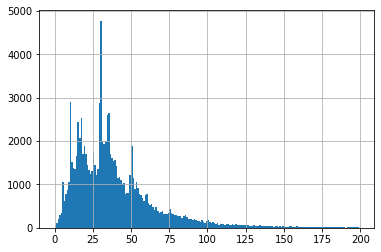

In [18]:
df['per']=df['rev_Mean']/df['phones']
df['per'].hist(bins=range(0,200,1))

In [19]:
df['per'].mode()

0    29.99
dtype: float64

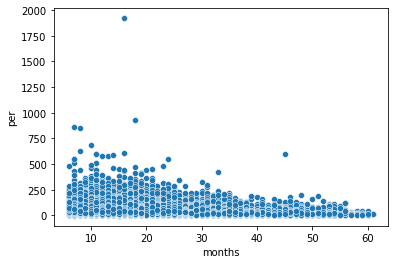

In [21]:
sns.scatterplot(x='months',y='per',data=df)

In [ ]:
df.columns

Index(['uniqsubs', 'actvsubs', 'new_cell', 'crclscod', 'asl_flag', 'totcalls',
       'totmou', 'totrev', 'adjrev', 'adjmou',
       ...
       'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean',
       'callfwdv_Mean', 'callwait_Mean', 'churn', 'months', 'avg_rev',
       'check'],
      dtype='object', length=102)

In [ ]:
for col in df.columns:
  if len(df[col].unique()) > 1000:
      print(col, '\t',len(df[col].unique()))

totcalls 	 12230
totmou 	 23752
totrev 	 76104
adjrev 	 75274
adjmou 	 23455
adjqty 	 12185
avgrev 	 14863
avgmou 	 57931
avgqty 	 34704
avg3mou 	 3108
avg3qty 	 1438
avg6mou 	 2942
avg6qty 	 1377
eqpdays 	 1556
Customer_ID 	 100000
rev_Mean 	 37469
mou_Mean 	 9731
totmrc_Mean 	 8492
ovrmou_Mean 	 2639
ovrrev_Mean 	 12316
vceovr_Mean 	 7517
roam_Mean 	 5338
change_mou 	 7712
change_rev 	 32538
plcd_vce_Mean 	 2907
recv_vce_Mean 	 1829
comp_vce_Mean 	 2316
cc_mou_Mean 	 9231
inonemin_Mean 	 1312
mou_cvce_Mean 	 68951
mou_cdat_Mean 	 4420
mou_rvce_Mean 	 51988
mouowylisv_Mean 	 26847
mouiwylisv_Mean 	 21287
peak_vce_Mean 	 2125
mou_peav_Mean 	 64094
mou_pead_Mean 	 3168
opk_vce_Mean 	 1928
mou_opkv_Mean 	 59693
mou_opkd_Mean 	 3539
attempt_Mean 	 2918
complete_Mean 	 2346
avg_rev 	 94050
check 	 96369


# 'churn'解約をターゲットとする。

In [ ]:
cols=[
'rev_Mean',
'ovrrev_Mean',
'change_rev',
'mou_cvce_Mean',
'mou_rvce_Mean',
'mouowylisv_Mean',
'mouiwylisv_Mean',
'mou_peav_Mean',
'mou_opkv_Mean']

In [ ]:
for col in cols:
  df[cols]=round(df[cols])

In [ ]:
cols=[
'mou_Mean',
'totmrc_Mean',
'ovrmou_Mean',
'vceovr_Mean',
'roam_Mean',
'change_mou',
'plcd_vce_Mean',
'recv_vce_Mean',
'comp_vce_Mean',
'cc_mou_Mean',
'inonemin_Mean',
'mou_cdat_Mean',
'peak_vce_Mean',
'mou_pead_Mean',
'opk_vce_Mean',
'mou_opkd_Mean',
'attempt_Mean',
'complete_Mean']

In [ ]:
for col in cols:
  df[col]=round(df[col])

In [ ]:
#for col in df.columns:
#  if len(df[col].unique()) > 100:
#      print(col, '\t',len(df[col].unique()))

In [ ]:
#df.drop(['Customer_ID'],axis=1,inplace=True)

In [ ]:
df['callwait_Mean'].dtype

dtype('float64')

In [ ]:
#for col in cols:
#  print(col,'\t',len(df[col].unique()))

In [ ]:
import gc
gc.collect()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)

scaler.transform(df)

array([[0.00000000e+00, 1.80180180e-02, 1.13636364e-01, ...,
        1.56739812e-03, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 3.93120393e-02, 1.59090909e-01, ...,
        2.66457680e-02, 0.00000000e+00, 9.09090909e-01],
       [0.00000000e+00, 8.19000819e-04, 1.13636364e-01, ...,
        0.00000000e+00, 1.00000000e+00, 9.45454545e-01],
       ...,
       [           nan,            nan,            nan, ...,
        0.00000000e+00, 0.00000000e+00, 4.54545455e-01],
       [           nan,            nan,            nan, ...,
        0.00000000e+00, 0.00000000e+00, 3.45454545e-01],
       [           nan,            nan,            nan, ...,
        0.00000000e+00, 1.00000000e+00, 3.45454545e-01]])

In [ ]:
df

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months
0,0.0,22.0,2.0,0.2475,0.0,0.0,0.0,0.0,0.0,-16.0,...,0.0,0.0,0.0,1.333333,5.0,4.0,0.0,0.333333,1,61
1,0.0,48.0,4.0,0.2475,2.0,0.0,1.0,0.0,0.0,53.0,...,0.0,0.0,0.0,9.333333,26.0,19.0,0.0,5.666667,0,56
2,0.0,1.0,2.0,0.0000,0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.333333,1.0,1.0,0.0,0.000000,1,58
3,0.0,1.0,4.0,0.0000,0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0,60
4,0.0,57.0,7.0,0.0000,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,10.333333,22.0,14.0,0.0,0.000000,0,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,2.000000,5.0,5.0,0.0,0.000000,1,25
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,4.000000,7.0,5.0,0.0,0.000000,0,27
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0,31
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,19.333333,55.0,42.0,0.0,0.000000,0,25


In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
X = df.drop('churn',axis=1) 
y = df['churn'] # 目的変数
# トレーニングデータ,テストデータの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2, random_state=0)

In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train) 

# パラメータ
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 分類
        'metric': {'auc'},
         'num_leaves': 20,             
        'max_depth':5,
        'min_data_in_leaf': 3,        
        'num_iteration': 100,            
        'learning_rate':0.03,
        'num_boost_round':100,
         'early_stopping_rounds':20, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.622971
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.624785
[3]	valid_0's auc: 0.627015
[4]	valid_0's auc: 0.627768
[5]	valid_0's auc: 0.627627
[6]	valid_0's auc: 0.631479
[7]	valid_0's auc: 0.632001
[8]	valid_0's auc: 0.632604
[9]	valid_0's auc: 0.632963
[10]	valid_0's auc: 0.633394
[11]	valid_0's auc: 0.63391
[12]	valid_0's auc: 0.634267
[13]	valid_0's auc: 0.635221
[14]	valid_0's auc: 0.63588
[15]	valid_0's auc: 0.635919
[16]	valid_0's auc: 0.636462
[17]	valid_0's auc: 0.636821
[18]	valid_0's auc: 0.637545
[19]	valid_0's auc: 0.637736
[20]	valid_0's auc: 0.637848
[21]	valid_0's auc: 0.638088
[22]	valid_0's auc: 0.638514
[23]	valid_0's auc: 0.638708
[24]	valid_0's auc: 0.639015
[25]	valid_0's auc: 0.639887
[26]	valid_0's auc: 0.640039
[27]	valid_0's auc: 0.640578
[28]	valid_0's auc: 0.640685
[29]	valid_0's auc: 0.641236
[30]	valid_0's auc: 0.641687
[31]	valid_0's auc: 0.641672
[32]	valid_0's auc: 0.641953
[33]	valid_0's auc: 0

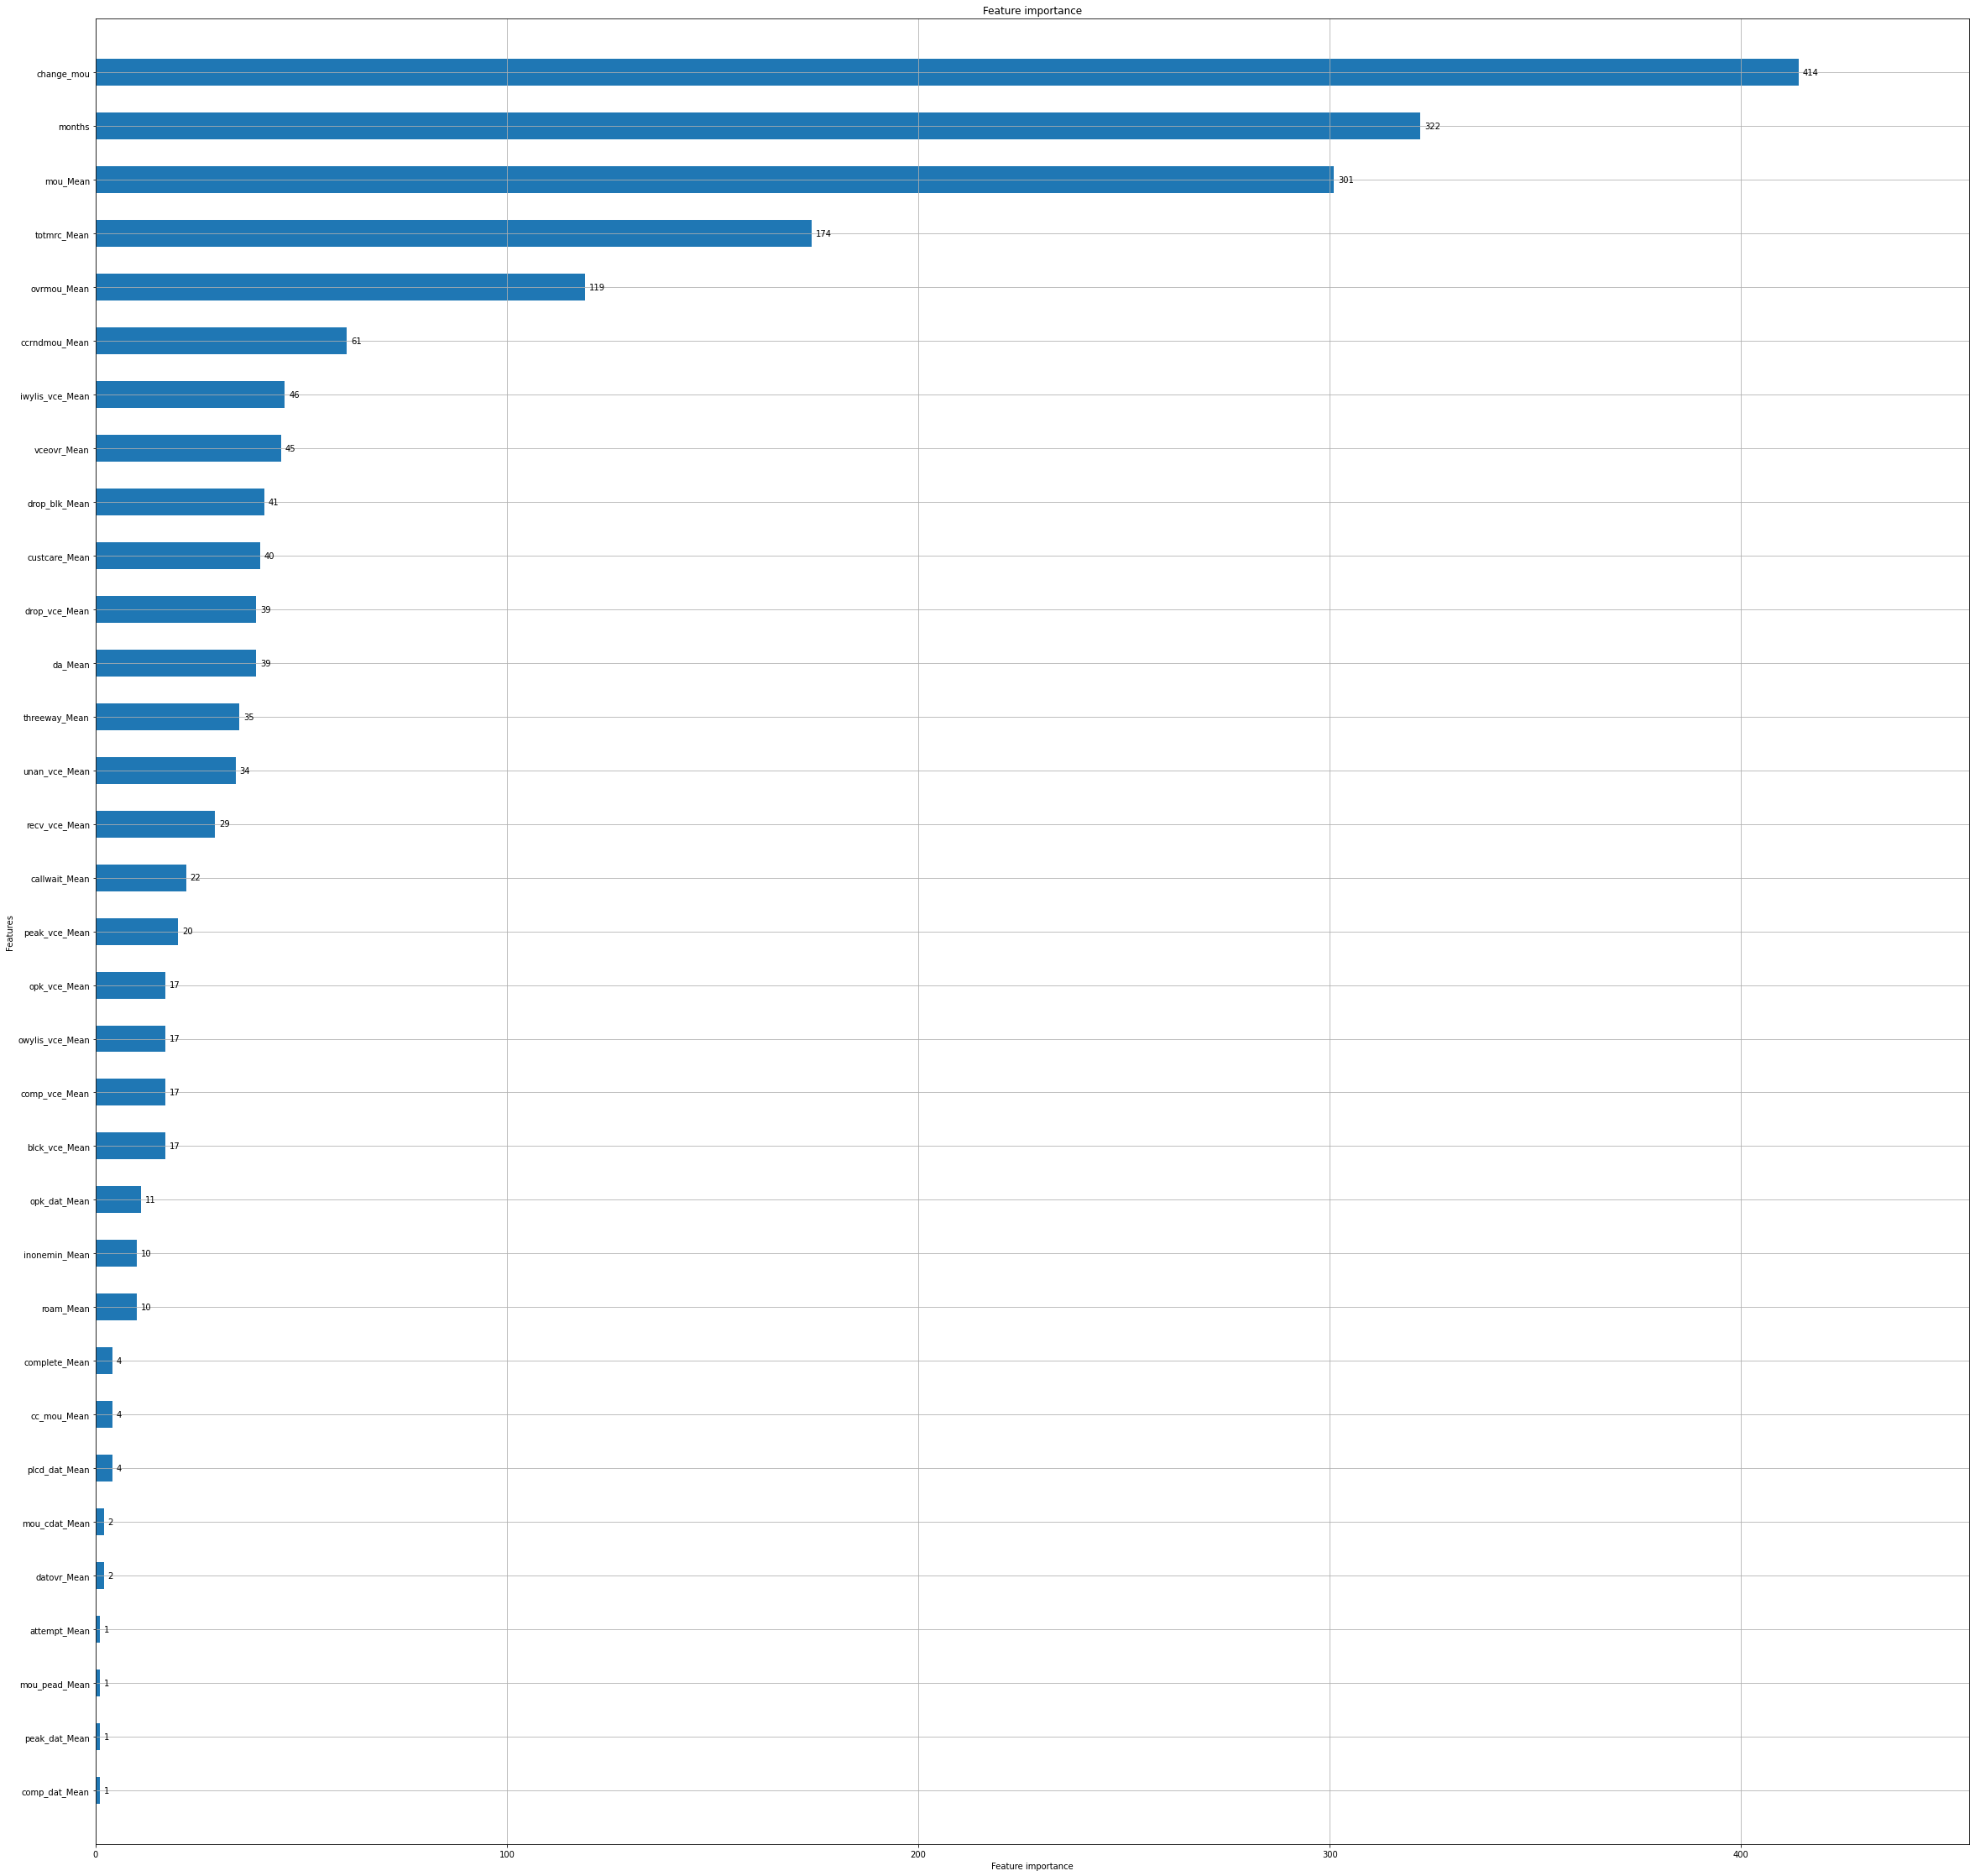

In [ ]:
lgb.plot_importance(model, height=0.5, figsize=(40,40))

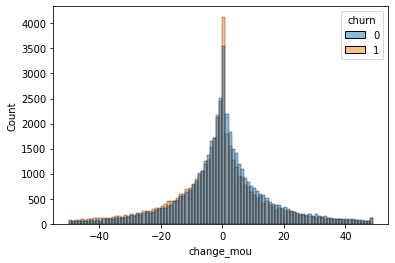

In [ ]:
sns.histplot(data=df, x="change_mou",bins=range(-50,50,1),hue='churn')

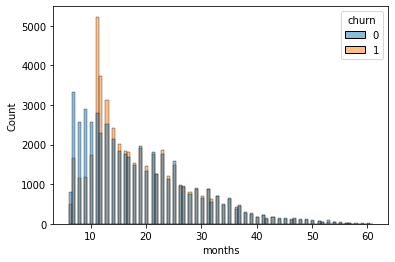

In [ ]:
sns.histplot(data=df, x="months",hue='churn')

# 12か月目に離脱している顧客が非常に多い

In [ ]:
X = df.loc[df['months']==12]
X = X.drop('churn',axis=1)
y = df.loc[df['months']==12,'churn'] # 目的変数
# トレーニングデータ,テストデータの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2, random_state=0)

In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train) 

# パラメータ
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 分類
        'metric': {'auc'},
         'num_leaves': 20,             
        'max_depth':5,
        'min_data_in_leaf': 3,        
        'num_iteration': 100,            
        'learning_rate':0.03,
        'num_boost_round':100,
         'early_stopping_rounds':20, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

[1]	valid_0's auc: 0.548285
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.552116
[3]	valid_0's auc: 0.55235
[4]	valid_0's auc: 0.552888
[5]	valid_0's auc: 0.553364
[6]	valid_0's auc: 0.555547
[7]	valid_0's auc: 0.554401
[8]	valid_0's auc: 0.559109
[9]	valid_0's auc: 0.555906
[10]	valid_0's auc: 0.555939
[11]	valid_0's auc: 0.555783
[12]	valid_0's auc: 0.551876
[13]	valid_0's auc: 0.555515
[14]	valid_0's auc: 0.558353
[15]	valid_0's auc: 0.559948
[16]	valid_0's auc: 0.567033
[17]	valid_0's auc: 0.567012
[18]	valid_0's auc: 0.567632
[19]	valid_0's auc: 0.569008
[20]	valid_0's auc: 0.569046
[21]	valid_0's auc: 0.568462
[22]	valid_0's auc: 0.568833
[23]	valid_0's auc: 0.569857
[24]	valid_0's auc: 0.569471
[25]	valid_0's auc: 0.569934
[26]	valid_0's auc: 0.570799
[27]	valid_0's auc: 0.569743
[28]	valid_0's auc: 0.571341
[29]	valid_0's auc: 0.571813
[30]	valid_0's auc: 0.572425
[31]	valid_0's auc: 0.57121
[32]	valid_0's auc: 0.571067
[33]	valid_0's auc: 0

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


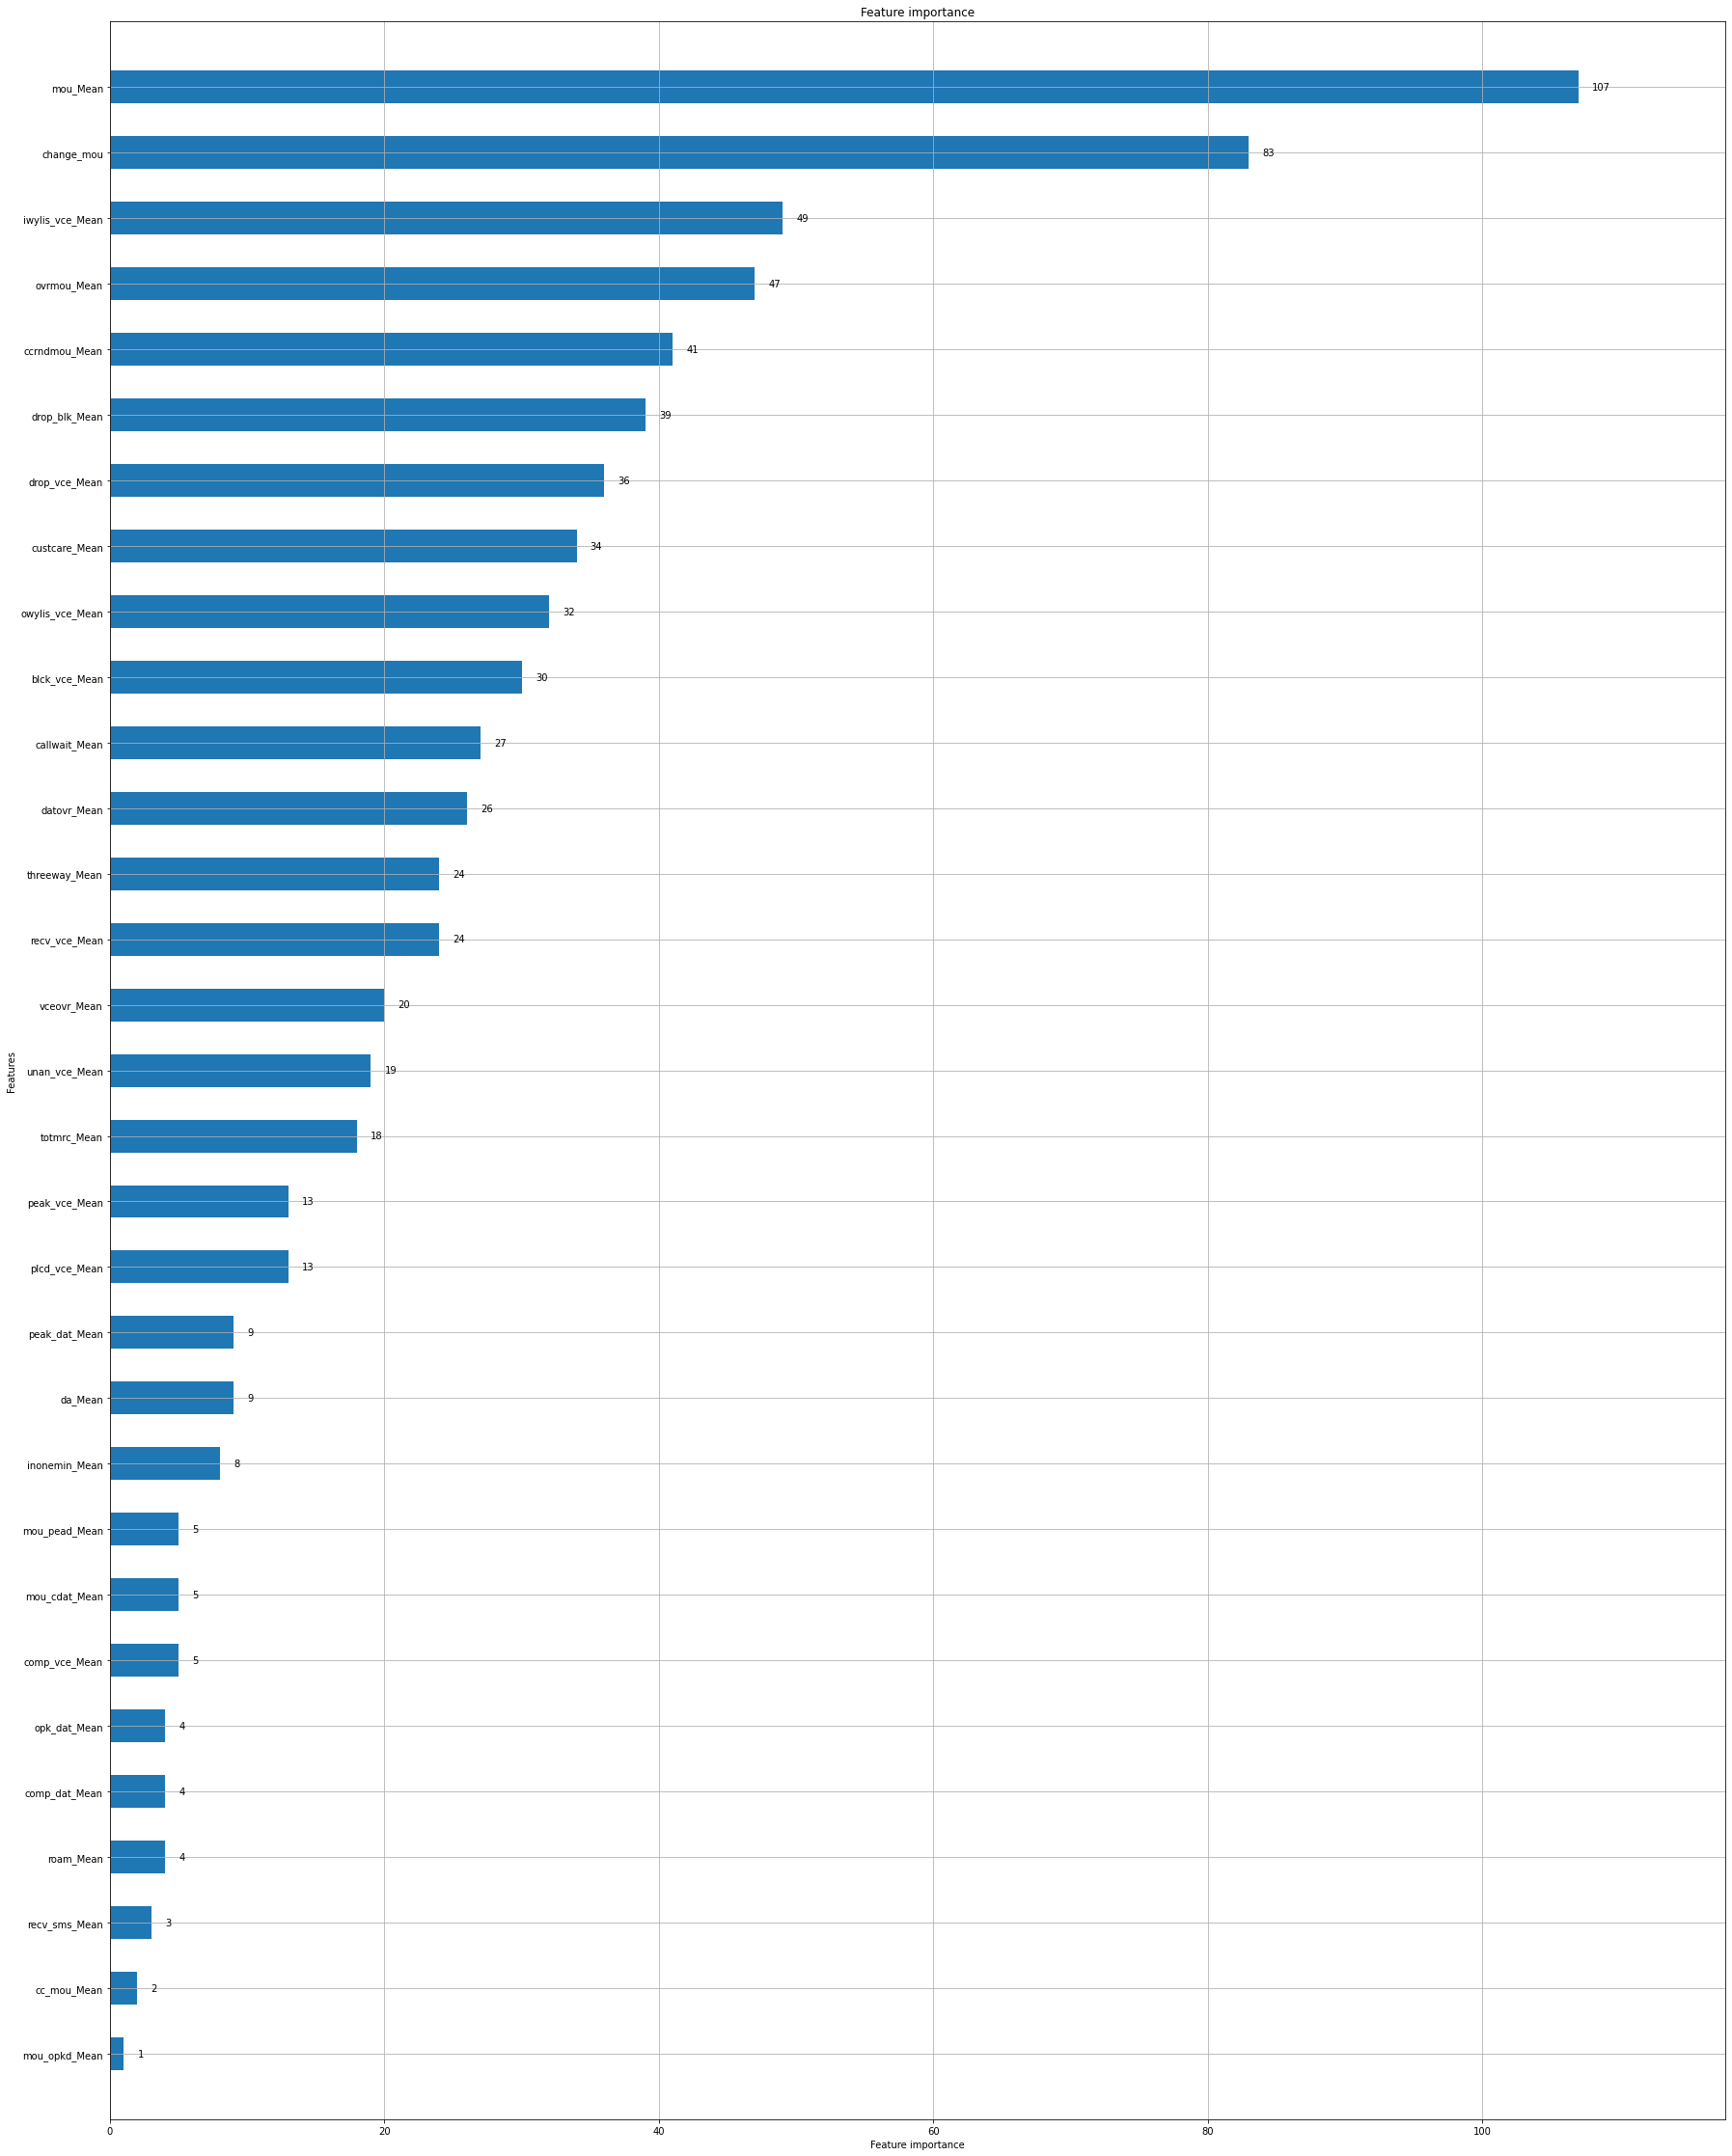

In [ ]:
lgb.plot_importance(model, height=0.5, figsize=(30,40))

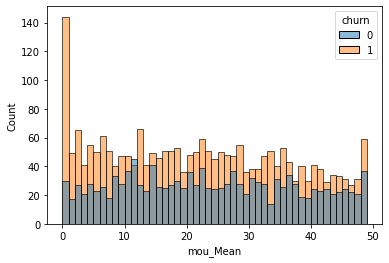

In [ ]:
sns.histplot(data=df.loc[df['months']==12], x="mou_Mean",bins=range(0,50,1),hue='churn')

# **月間使用量が減少した顧客に脱退が多い**

In [ ]:
record.loc[(record['months']==12)&(record['churn']==1),'rev_Mean'].mode()

0    29.99
dtype: float64

In [ ]:
record.loc[(record['months']==12)&(record['churn']==0),'rev_Mean'].mode()

0    29.99
dtype: float64

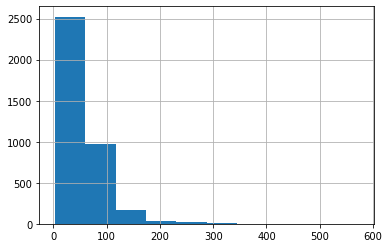

In [ ]:
record.loc[(record['months']==12)&(record['churn']==1),'rev_Mean'].hist()

In [ ]:
#df.loc[(df['months']==12)&(df['churn']==1),'avg6mou'].hist(bins=50)

In [ ]:
#df.loc[(df['months']==12)&(df['churn']==0),'avg3mou'].hist(bins=50)

In [ ]:
#df.loc[(df['months']==12)&(df['churn']==0),'avg6mou'].hist(bins=50)

In [ ]:
#df['dec']=df['avg6mou']-df['avg3mou']
#sns.histplot(data=df.loc[df['months']==12], bins=range(-50,50,1), x="dec",hue='churn')

Mean monthly revenue (charge amount)

In [ ]:
record.loc[record['rev_Mean'].notna(),'rev_Mean']

0         23.997500
1         57.492500
2         16.990000
3         38.000000
4         55.230000
            ...    
99984     85.150000
99985     71.993333
99986    117.490000
99990     29.990000
99993     95.170000
Name: rev_Mean, Length: 99643, dtype: float64

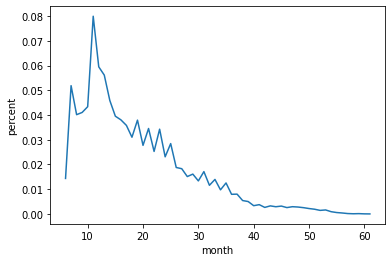

In [ ]:
ser = record.loc[record['rev_Mean'].notna()].groupby('months')['rev_Mean'].sum()/record.loc[record['rev_Mean'].notna(),'rev_Mean'].sum()
dfp = pd.DataFrame({'month':ser.keys(), 'percent':ser})
sns.lineplot(x='month', y='percent',data=dfp)

# 顧客の累計支払額のシェアBilling adjusted total revenue over the life of the customer

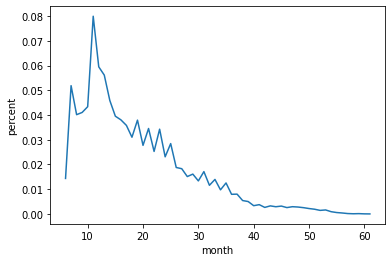

In [ ]:
ser = record.groupby('months')['rev_Mean'].sum()/record['rev_Mean'].sum()
dfp = pd.DataFrame({'month':ser.keys(), 'percent':ser})
sns.lineplot(x='month', y='percent',data=dfp)

Average monthly number of calls over the life of the customer

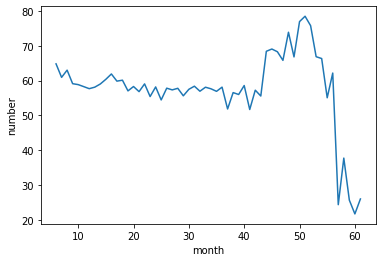

In [ ]:
ser = record.groupby('months')['rev_Mean'].mean()
dfp = pd.DataFrame({'month':ser.keys(), 'number':ser})
sns.lineplot(x='month', y='number',data=dfp)

Average monthly revenue over the life of the customer

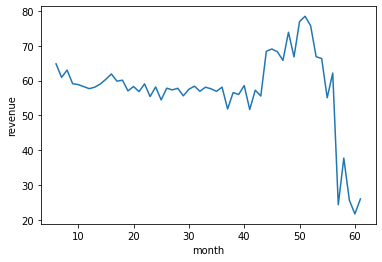

In [ ]:
ser = record.groupby('months')['rev_Mean'].mean()
dfp = pd.DataFrame({'month':ser.keys(), 'revenue':ser})
sns.lineplot(x='month', y='revenue',data=dfp)

顧客数のシェア

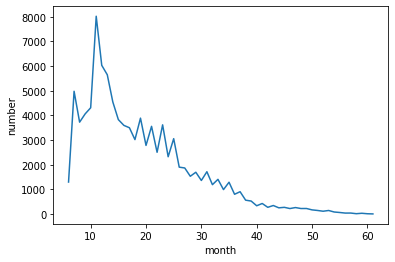

In [ ]:
ser = record.groupby('months')['rev_Mean'].count()
dfp = pd.DataFrame({'month':ser.keys(), 'number':ser})
sns.lineplot(x='month', y='number',data=dfp)

In [ ]:
record.loc[record['rev_Mean']-record['ovrrev_Mean']-record['totmrc_Mean']<0]

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months
4,55.2300,570.500000,71.980,0.0000,0.0,0.000,0.000,0.000,0.00,38.500000,...,0.000000,218.086667,0.000000,10.333333,222.333333,137.000000,0.0,0.000000,0,57
7,38.0525,682.500000,52.490,0.2475,0.0,0.000,0.000,0.000,0.00,147.500000,...,0.000000,431.153333,0.000000,10.666667,97.000000,73.333333,0.0,0.666667,0,53
10,62.1275,97.500000,65.985,2.4750,0.0,0.000,0.000,0.000,0.00,23.500000,...,0.000000,70.420000,0.000000,0.333333,19.666667,15.333333,0.0,0.000000,0,59
19,50.9650,162.000000,69.990,0.0000,2.5,0.975,0.000,0.975,0.00,-58.000000,...,1.333333,66.353333,2.373333,2.000000,62.000000,51.333333,0.0,0.000000,0,56
28,98.4225,608.000000,94.990,1.2375,41.5,12.195,7.125,5.070,0.00,-563.000000,...,0.000000,151.060000,0.000000,9.000000,284.666667,206.000000,0.0,4.666667,1,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99973,0.0000,76.000000,29.670,0.0000,0.0,0.000,0.000,0.000,0.00,0.000000,...,0.000000,35.530000,0.000000,6.666667,62.333333,43.000000,0.0,0.000000,0,30
99981,34.9900,6.333333,44.990,0.0000,0.0,0.000,0.000,0.000,0.00,-6.333333,...,0.000000,8.256667,0.000000,1.333333,13.666667,11.666667,0.0,0.000000,1,30
99984,85.1500,815.000000,87.990,0.0000,1.0,0.390,0.000,0.390,0.39,0.000000,...,0.000000,189.606667,0.000000,12.000000,83.333333,60.000000,0.0,0.000000,1,27
99986,117.4900,384.000000,29.990,0.0000,250.0,87.500,87.500,0.000,0.00,0.000000,...,0.000000,32.786667,0.000000,5.000000,169.333333,138.000000,0.0,0.000000,1,30


org.loc[org['rev_Mean']-org['ovrrev_Mean']-org['totmrc_Mean']>0] 42362

org.loc[org['rev_Mean']-org['ovrrev_Mean']-org['totmrc_Mean']<0 50198


In [ ]:
client.columns

Index(['uniqsubs', 'actvsubs', 'new_cell', 'crclscod', 'asl_flag', 'totcalls',
       'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou',
       'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty',
       'avg6rev', 'prizm_social_one', 'area', 'dualband', 'refurb_new',
       'hnd_price', 'phones', 'models', 'hnd_webcap', 'truck', 'rv', 'ownrent',
       'lor', 'dwlltype', 'marital', 'adults', 'infobase', 'income',
       'numbcars', 'HHstatin', 'dwllsize', 'forgntvl', 'ethnic', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd', 'eqpdays',
       'Customer_ID'],
      dtype='object')

In [ ]:
for col in client.columns:
  print(col,'\t',len(client[col].unique()))

uniqsubs 	 15
actvsubs 	 12
new_cell 	 3
crclscod 	 54
asl_flag 	 2
totcalls 	 12230
totmou 	 23752
totrev 	 76104
adjrev 	 75274
adjmou 	 23455
adjqty 	 12185
avgrev 	 14863
avgmou 	 57931
avgqty 	 34704
avg3mou 	 3108
avg3qty 	 1438
avg3rev 	 507
avg6mou 	 2942
avg6qty 	 1377
avg6rev 	 452
prizm_social_one 	 6
area 	 20
dualband 	 5
refurb_new 	 3
hnd_price 	 18
phones 	 25
models 	 15
hnd_webcap 	 4
truck 	 3
rv 	 3
ownrent 	 3
lor 	 17
dwlltype 	 3
marital 	 6
adults 	 7
infobase 	 3
income 	 10
numbcars 	 4
HHstatin 	 7
dwllsize 	 16
forgntvl 	 3
ethnic 	 18
kid0_2 	 3
kid3_5 	 3
kid6_10 	 3
kid11_15 	 3
kid16_17 	 3
creditcd 	 3
eqpdays 	 1556
Customer_ID 	 100000


In [ ]:
cols = [col for col in client.columns if client[col].dtype == 'object']

In [ ]:
df=pd.get_dummies(client,columns=cols)

In [ ]:
df

,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,...,kid3_5_U,kid3_5_Y,kid6_10_U,kid6_10_Y,kid11_15_U,kid11_15_Y,kid16_17_U,kid16_17_Y,creditcd_N,creditcd_Y
0,2,1,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,...,1,0,1,0,1,0,1,0,0,1
1,1,1,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,...,1,0,1,0,1,0,1,0,0,1
2,1,1,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,...,0,1,1,0,1,0,1,0,0,1
3,1,1,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,...,1,0,1,0,1,0,1,0,0,1
4,1,1,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,...,1,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,1,3771,9534.00000,1594.83,1561.14,9494.00,3751,74.34,452.10,...,1,0,1,0,0,1,1,0,0,1
99996,1,1,3675,8887.00000,1517.10,1451.85,8805.00,3629,72.59,440.25,...,1,0,0,1,0,1,0,1,0,1
99997,1,1,1271,9336.00000,1114.91,1055.93,9234.00,1238,55.58,486.00,...,0,1,1,0,1,0,1,0,1,0
99998,1,1,10082,20784.00000,2669.20,2593.26,20488.00,9921,123.49,975.62,...,1,0,1,0,1,0,1,0,1,0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x=df.drop(['totrev'],axis=1,inplace=True)
y=df['totrev']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = LogisticRegression(solver='liblinear') 
clf.fit(x_train,y_train)
score = accuracy_score(y_test, y_pred)